In [30]:
import torch
from transformers import *
import json
import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import defaultdict
from datetime import datetime

In [31]:
def untokenized_reader(filename, typ='original'):
    # return list of original / words / lemma / pos
    with open(filename) as f:
        data = json.load(f)
    res = []
    assert typ in ['original', 'words', 'lemma', 'pos'], 'typ should in [original, words, lemma, pos]'
    
    if typ == 'original':
        for j in data:
            res.append(j['headline'])
    if typ == 'words':
        for j in data:
            res.append(j['words'])
    if typ == 'lemma':
        for j in data:
            res.append(j['lemma'])
    if typ == 'pos':
        for j in data:
            res.append(j['pos'])    
    return res

def padding(tokenized):
    max_len = 0
    for i in tokenized:
        if len(i) > max_len:
            max_len = len(i)
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized])
    return padded

def df_label(target):
    num_cls = len(target)
    df = pd.DataFrame(data=np.array(target[0]))
    df[len(df.columns)] = 0
    for label in range(1, num_cls):
        df1 = pd.DataFrame(data=np.array(target[label]))
        df1[len(df1.columns)] = label
        df = pd.concat([df, df1])
        
    return df
        
        

In [32]:
def transformer_embedding(target:list, choice:int):
    MODELS = [(BertModel,       BertTokenizer,       'bert-base-uncased'),
              (OpenAIGPTModel,  OpenAIGPTTokenizer,  'openai-gpt'),
              (GPT2Model,       GPT2Tokenizer,       'gpt2'),
              (CTRLModel,       CTRLTokenizer,       'ctrl'),
              (TransfoXLModel,  TransfoXLTokenizer,  'transfo-xl-wt103'),
              (XLNetModel,      XLNetTokenizer,      'xlnet-base-cased'),
              (XLMModel,        XLMTokenizer,        'xlm-mlm-enfr-1024'),
              (DistilBertModel, DistilBertTokenizer, 'distilbert-base-cased'),
              (RobertaModel,    RobertaTokenizer,    'roberta-base'),
              (XLMRobertaModel, XLMRobertaTokenizer, 'xlm-roberta-base'),
             ]
    
    print("Processing %d sentence"%len(target))
    model_class, tokenizer_class, pretrained_weights = MODELS[choice]
    
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)
    tokenized = [tokenizer.encode(x, add_special_tokens=True) for x in target]
    
    padded = padding(tokenized)
    input_ids = torch.tensor(np.array(padded))
    
    with torch.no_grad():
        last_hidden_states = model(input_ids)
        #Slice the output for the first position for all the sequences, take all hidden unit outputs
        embed = last_hidden_states[0][:,0,:].numpy()
    return embed

In [33]:
def untokenized_reader_time(filename):
    # return list of original / words / lemma / pos
    with open(filename) as f:
        data = json.load(f)
    res = defaultdict(list)
    
    for d in data:
        time = datetime.strptime(d['date'],'%Y-%m-%d').month
        res[time].append(d['headline'])
    return res

In [34]:
data_fox = untokenized_reader("foxnews_headlines.json")
data_msnbc = untokenized_reader("msnbc_headlines.json")

In [35]:
emb_fox = transformer_embedding(data_fox, 2)
emb_msnbc = transformer_embedding(data_msnbc, 2)

Processing 3115 sentence
Processing 957 sentence


In [36]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
%matplotlib inline


In [37]:
df_fox = df_label([emb_fox])
df_msnbc = df_label([emb_msnbc])

In [38]:
df_fox = df_fox.iloc[:, :-1]
df_msnbc = df_fox.iloc[:, :-1]

In [39]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=1, n_iter=15000, metric="cosine", perplexity=100)
embs_fox = tsne.fit_transform(df_fox)
embs_msnbc = tsne.fit_transform(df_msnbc)

In [40]:
df_tsne_fox = pd.DataFrame({'x' : [], 'y' : []})
df_tsne_fox['x'] = embs_fox[:, 0]
df_tsne_fox['y'] = embs_fox[:, 1]

df_tsne_msnbc = pd.DataFrame({'x' : [], 'y' : []})
df_tsne_msnbc['x'] = embs_msnbc[:, 0]
df_tsne_msnbc['y'] = embs_msnbc[:, 1]

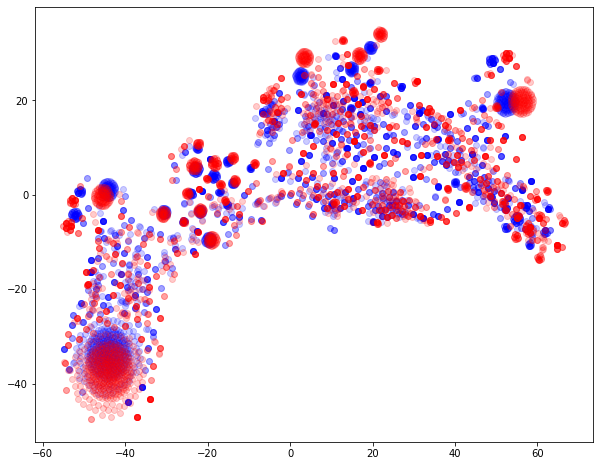

In [41]:
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
ax.scatter(df_tsne_fox.x, df_tsne_fox.y, alpha=.2, c='b')
ax.scatter(df_tsne_msnbc.x, df_tsne_msnbc.y, alpha=.2, c='r')

plt.savefig("tsne.png")

In [77]:
import time                   # To time processes
import warnings               # To suppress warnings

import numpy as np            # Data manipulation
import pandas as pd           # Dataframe manipulatio 
import matplotlib.pyplot as plt                   # For graphics
import seaborn as sns
import plotly.plotly as py #For World Map
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import os                     # For os related operations
import sys                    # For data size

In [78]:
def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

In [84]:
df_kmean = df_label([emb_fox, emb_fox])
clust_labels, cent = doKmeans(df_kmean.iloc[:,:-1], 2)
kmeans = pd.DataFrame(clust_labels)
df_kmean.insert((df_kmean.shape[1]),'kmeans',kmeans)

# PCA

In [7]:
from sklearn.preprocessing import StandardScaler

emb_fox = transformer_embedding(data_fox, 2)
emb_msnbc = transformer_embedding(data_msnbc, 2)

df_pca = df_label([emb_fox, emb_fox])
print(df_pca.shape)
x = df_pca.iloc[:, :-1].values
y = df_pca.iloc[:,-1].values
x = StandardScaler().fit_transform(x)


Processing 3115 sentence
Processing 957 sentence
(6230, 769)


(6230, 768)

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf['cls'] = y

principalDf

,principal component 1,principal component 2,cls
0,-1.169111,-1.484179,0
1,-1.169075,-1.484170,0
2,1.813834,16.032101,0
3,-12.707455,-1.130053,0
4,-14.333671,-3.500875,0
5,-0.424356,-3.038198,0
6,0.075042,-9.510585,0
7,-14.333671,-3.500876,0
8,9.009856,2.143787,0
9,-3.674312,-3.004683,0


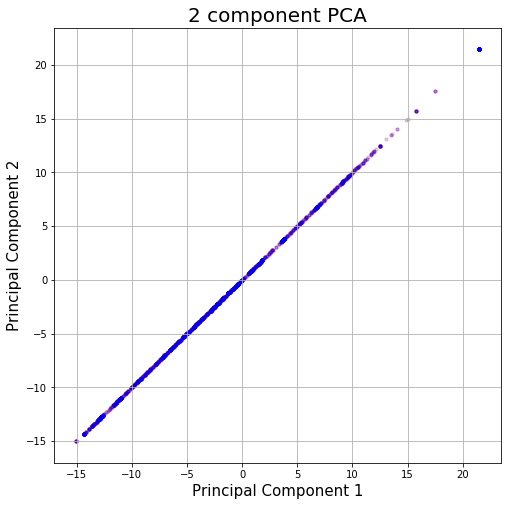

In [28]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
colors = ['r', 'b']
for i in range(len(colors)):
    indicesToKeep = principalDf['cls'] == i
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 1']
               , c = colors[i]
               , s = 10
              , alpha = 0.1)



ax.grid()

array([0, 0, 0, ..., 1, 1, 1])